# SSD
# keywords: ssd, mobilenet, nms, threshold

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import math
from typing import List, Tuple
from torch.nn import Conv2d, Sequential, ModuleList, BatchNorm2d
import torch.nn.functional as F
import itertools


from collections import namedtuple
GraphPath = namedtuple("GraphPath", ['s0', 'name', 's1'])

We are going to use MobileNetv2 as a backbone of our network.

Main ideas (v1):

1. Residuals (as is resnet):

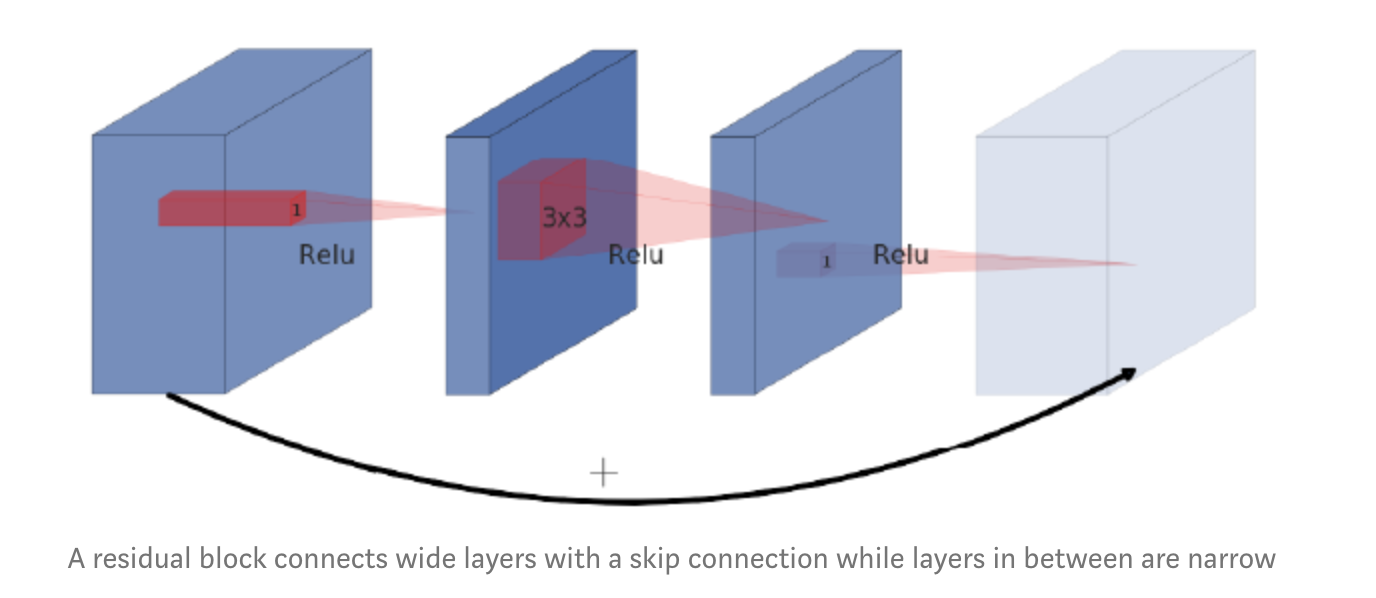

2. Separable convolutions:

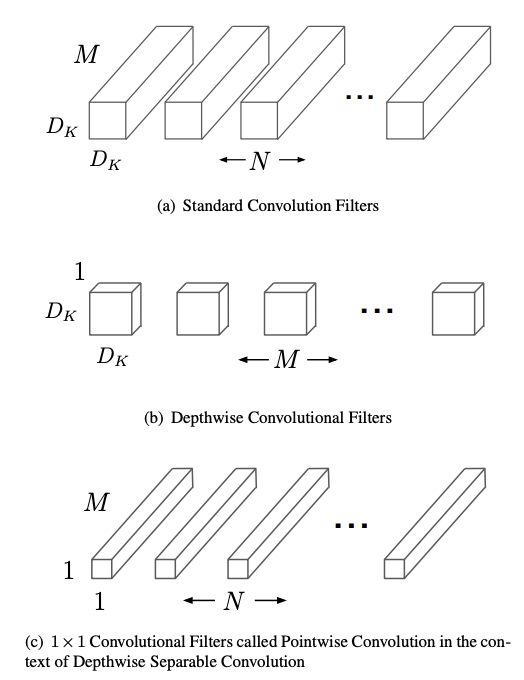

Changes in v2:
Bottleneck and inverse residual:

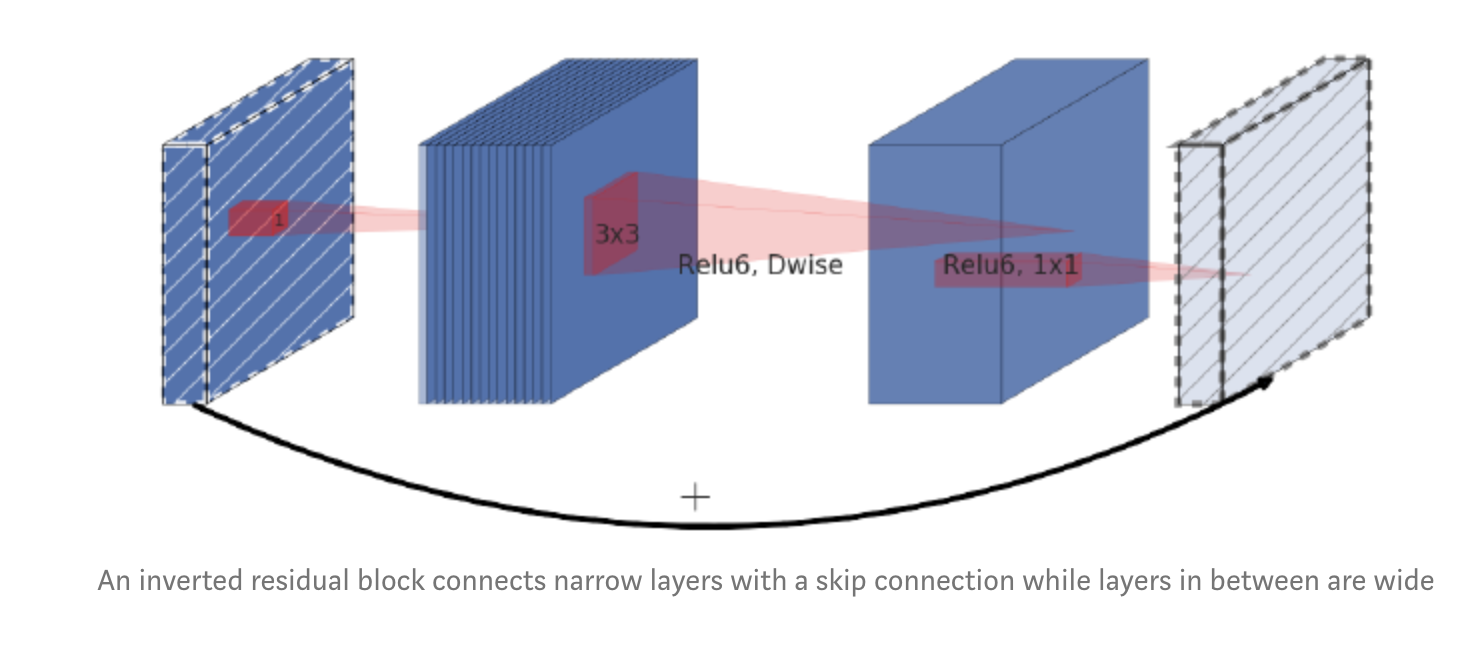

In [ ]:
def conv_bn(inp, oup, stride, use_batch_norm=True, onnx_compatible=False):
    ReLU = nn.ReLU if onnx_compatible else nn.ReLU6

    if use_batch_norm:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
            nn.BatchNorm2d(oup),
            ReLU(inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
            ReLU(inplace=True)
        )


def conv_1x1_bn(inp, oup, use_batch_norm=True, onnx_compatible=False):
    ReLU = nn.ReLU if onnx_compatible else nn.ReLU6
    if use_batch_norm:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
            ReLU(inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
            ReLU(inplace=True)
        )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_batch_norm=True, onnx_compatible=False):
        super(InvertedResidual, self).__init__()
        ReLU = nn.ReLU if onnx_compatible else nn.ReLU6

        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            if use_batch_norm:
                self.conv = nn.Sequential(
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )
            else:
                self.conv = nn.Sequential(
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                )
        else:
            if use_batch_norm:
                self.conv = nn.Sequential(
                    # pw
                    nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    ReLU(inplace=True),
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    nn.BatchNorm2d(hidden_dim),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                    nn.BatchNorm2d(oup),
                )
            else:
                self.conv = nn.Sequential(
                    # pw
                    nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                    ReLU(inplace=True),
                    # dw
                    nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                    ReLU(inplace=True),
                    # pw-linear
                    nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

def SeparableConv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, onnx_compatible=False):
    ReLU = nn.ReLU if onnx_compatible else nn.ReLU6
    return Sequential(
        Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size,
               groups=in_channels, stride=stride, padding=padding),
        BatchNorm2d(in_channels),
        ReLU(),
        Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
    )

class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1., dropout_ratio=0.2,
                 use_batch_norm=True, onnx_compatible=False):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2, onnx_compatible=onnx_compatible)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s,
                                               expand_ratio=t, use_batch_norm=use_batch_norm,
                                               onnx_compatible=onnx_compatible))
                else:
                    self.features.append(block(input_channel, output_channel, 1,
                                               expand_ratio=t, use_batch_norm=use_batch_norm,
                                               onnx_compatible=onnx_compatible))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel,
                                         use_batch_norm=use_batch_norm, onnx_compatible=onnx_compatible))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

Let's have a look at SSD implementation based on mobilenet (from https://github.com/qfgaohao/pytorch-ssd).

SSD paper: https://arxiv.org/pdf/1512.02325.pdf.


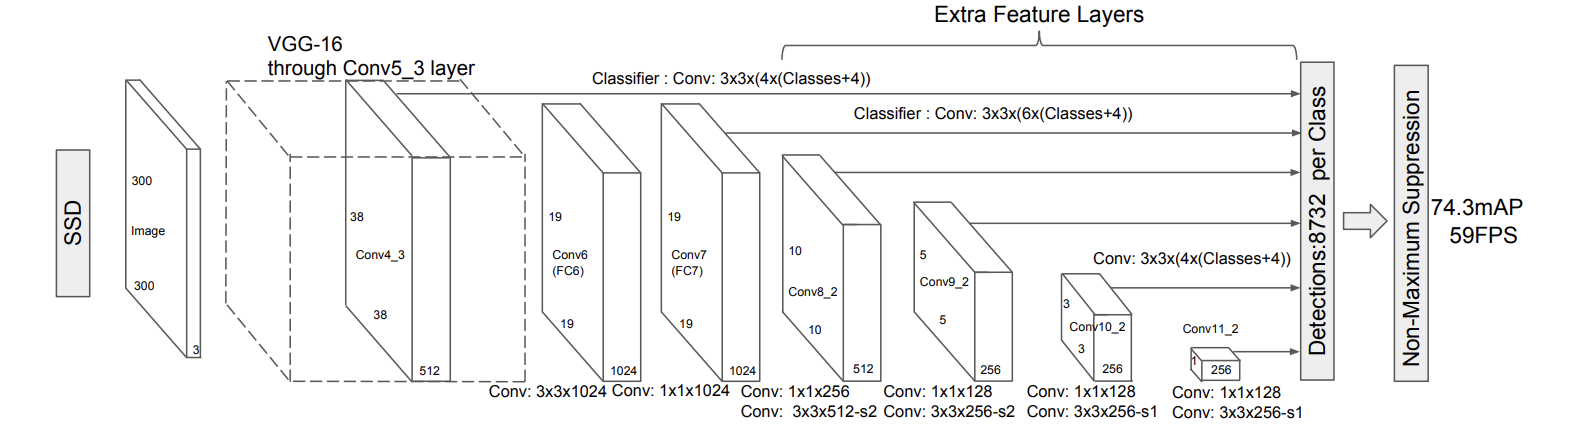

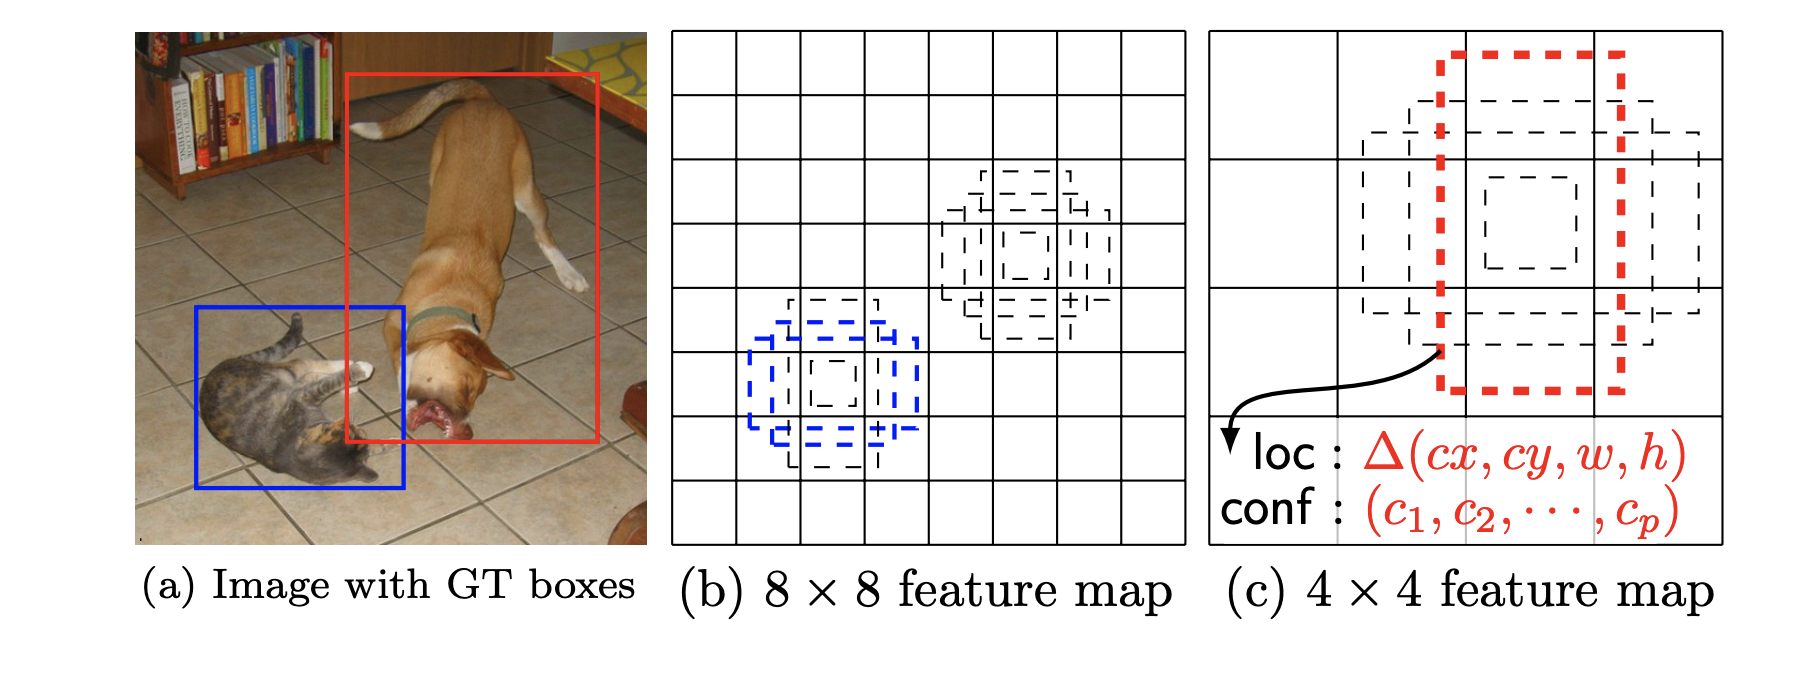

For each bounding box we output: per_class score and center offset.

In [ ]:
def convert_locations_to_boxes(locations, priors, center_variance,
                               size_variance):
    """Convert regressional location results of SSD into boxes in the form of (center_x, center_y, h, w).
    The conversion:
        $$predicted\_center * center_variance = \frac {real\_center - prior\_center} {prior\_hw}$$
        $$exp(predicted\_hw * size_variance) = \frac {real\_hw} {prior\_hw}$$
    We do it in the inverse direction here.
    Args:
        locations (batch_size, num_priors, 4): the regression output of SSD. It will contain the outputs as well.
        priors (num_priors, 4) or (batch_size/1, num_priors, 4): prior boxes.
        center_variance: a float used to change the scale of center.
        size_variance: a float used to change of scale of size.
    Returns:
        boxes:  priors: [[center_x, center_y, h, w]]. All the values
            are relative to the image size.
    """
    # priors can have one dimension less.
    if priors.dim() + 1 == locations.dim():
        priors = priors.unsqueeze(0)
    return torch.cat([
        locations[..., :2] * center_variance * priors[..., 2:] + priors[..., :2],
        torch.exp(locations[..., 2:] * size_variance) * priors[..., 2:]
    ], dim=locations.dim() - 1)


In [ ]:
def center_form_to_corner_form(locations):
    return torch.cat([locations[..., :2] - locations[..., 2:]/2,
                     locations[..., :2] + locations[..., 2:]/2], locations.dim() - 1) 

In [ ]:
class SSD(nn.Module):
    def __init__(self, num_classes: int, base_net: nn.ModuleList, source_layer_indexes: List[int],
                 extras: nn.ModuleList, classification_headers: nn.ModuleList,
                 regression_headers: nn.ModuleList, is_test=False, config=None, device=None):

        super(SSD, self).__init__()

        self.num_classes = num_classes
        self.base_net = base_net
        self.source_layer_indexes = source_layer_indexes
        self.extras = extras
        self.classification_headers = classification_headers
        self.regression_headers = regression_headers
        self.is_test = is_test
        self.config = config

        # register layers in source_layer_indexes by adding them to a module list
        self.source_layer_add_ons = nn.ModuleList([t[1] for t in source_layer_indexes
                                                   if isinstance(t, tuple) and not isinstance(t, GraphPath)])
        if device:
            self.device = device
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if is_test:
            self.config = config
            self.priors = config.priors.to(self.device)
            
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        confidences = []
        locations = []
        start_layer_index = 0
        header_index = 0
        for end_layer_index in self.source_layer_indexes:
            if isinstance(end_layer_index, GraphPath):
                path = end_layer_index
                end_layer_index = end_layer_index.s0
                added_layer = None
            elif isinstance(end_layer_index, tuple):
                added_layer = end_layer_index[1]
                end_layer_index = end_layer_index[0]
                path = None
            else:
                added_layer = None
                path = None
            for layer in self.base_net[start_layer_index: end_layer_index]:
                x = layer(x)
            if added_layer:
                y = added_layer(x)
            else:
                y = x
            if path:
                sub = getattr(self.base_net[end_layer_index], path.name)
                for layer in sub[:path.s1]:
                    x = layer(x)
                y = x
                for layer in sub[path.s1:]:
                    x = layer(x)
                end_layer_index += 1
            start_layer_index = end_layer_index
            confidence, location = self.compute_header(header_index, y)
            header_index += 1
            confidences.append(confidence)
            locations.append(location)

        for layer in self.base_net[end_layer_index:]:
            x = layer(x)

        for layer in self.extras:
            x = layer(x)
            confidence, location = self.compute_header(header_index, x)
            header_index += 1
            confidences.append(confidence)
            locations.append(location)

        confidences = torch.cat(confidences, 1)
        locations = torch.cat(locations, 1)
        
        if self.is_test:
            confidences = F.softmax(confidences, dim=2)
            boxes = convert_locations_to_boxes(
                locations, self.priors, self.config.center_variance, self.config.size_variance
            )
            boxes = center_form_to_corner_form(boxes)
            return confidences, boxes
        else:
            return confidences, locations

    def compute_header(self, i, x):
        confidence = self.classification_headers[i](x)
        confidence = confidence.permute(0, 2, 3, 1).contiguous()
        confidence = confidence.view(confidence.size(0), -1, self.num_classes)

        location = self.regression_headers[i](x)
        location = location.permute(0, 2, 3, 1).contiguous()
        location = location.view(location.size(0), -1, 4)

        return confidence, location

    def init_from_base_net(self, model):
        self.base_net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage), strict=True)
        self.source_layer_add_ons.apply(_xavier_init_)
        self.extras.apply(_xavier_init_)
        self.classification_headers.apply(_xavier_init_)
        self.regression_headers.apply(_xavier_init_)

    def init_from_pretrained_ssd(self, model):
        state_dict = torch.load(model, map_location=lambda storage, loc: storage)
        state_dict = {k: v for k, v in state_dict.items() if not (k.startswith("classification_headers") or k.startswith("regression_headers"))}
        model_dict = self.state_dict()
        model_dict.update(state_dict)
        self.load_state_dict(model_dict)
        self.classification_headers.apply(_xavier_init_)
        self.regression_headers.apply(_xavier_init_)

    def init(self):
        self.base_net.apply(_xavier_init_)
        self.source_layer_add_ons.apply(_xavier_init_)
        self.extras.apply(_xavier_init_)
        self.classification_headers.apply(_xavier_init_)
        self.regression_headers.apply(_xavier_init_)

    def load(self, model):
        self.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))

    def save(self, model_path):
        torch.save(self.state_dict(), model_path)

In [ ]:
SSDBoxSizes = namedtuple('SSDBoxSizes', ['min', 'max'])

SSDSpec = namedtuple('SSDSpec', ['feature_map_size', 'shrinkage', 'box_sizes', 'aspect_ratios'])


def generate_ssd_priors(specs: List[SSDSpec], image_size, clamp=True) -> torch.Tensor:
    """Generate SSD Prior Boxes.
    It returns the center, height and width of the priors. The values are relative to the image size
    Args:
        specs: SSDSpecs about the shapes of sizes of prior boxes. i.e.
            specs = [
                SSDSpec(38, 8, SSDBoxSizes(30, 60), [2]),
                SSDSpec(19, 16, SSDBoxSizes(60, 111), [2, 3]),
                SSDSpec(10, 32, SSDBoxSizes(111, 162), [2, 3]),
                SSDSpec(5, 64, SSDBoxSizes(162, 213), [2, 3]),
                SSDSpec(3, 100, SSDBoxSizes(213, 264), [2]),
                SSDSpec(1, 300, SSDBoxSizes(264, 315), [2])
            ]
        image_size: image size.
        clamp: if true, clamp the values to make fall between [0.0, 1.0]
    Returns:
        priors (num_priors, 4): The prior boxes represented as [[center_x, center_y, w, h]]. All the values
            are relative to the image size.
    """
    priors = []
    for spec in specs:
        scale = image_size / spec.shrinkage
        for j, i in itertools.product(range(spec.feature_map_size), repeat=2):
            x_center = (i + 0.5) / scale
            y_center = (j + 0.5) / scale

            # small sized square box
            size = spec.box_sizes.min
            h = w = size / image_size
            priors.append([
                x_center,
                y_center,
                w,
                h
            ])

            # big sized square box
            size = math.sqrt(spec.box_sizes.max * spec.box_sizes.min)
            h = w = size / image_size
            priors.append([
                x_center,
                y_center,
                w,
                h
            ])

            # change h/w ratio of the small sized box
            size = spec.box_sizes.min
            h = w = size / image_size
            for ratio in spec.aspect_ratios:
                ratio = math.sqrt(ratio)
                priors.append([
                    x_center,
                    y_center,
                    w * ratio,
                    h / ratio
                ])
                priors.append([
                    x_center,
                    y_center,
                    w / ratio,
                    h * ratio
                ])

    priors = torch.tensor(priors)
    if clamp:
        torch.clamp(priors, 0.0, 1.0, out=priors)
    return priors

class config: 
  image_size = 300
  image_mean = np.array([127, 127, 127])  # RGB layout
  image_std = 128.0
  iou_threshold = 0.45
  center_variance = 0.1
  size_variance = 0.2

  specs = [
      SSDSpec(19, 16, SSDBoxSizes(60, 105), [2, 3]),
      SSDSpec(10, 32, SSDBoxSizes(105, 150), [2, 3]),
      SSDSpec(5, 64, SSDBoxSizes(150, 195), [2, 3]),
      SSDSpec(3, 100, SSDBoxSizes(195, 240), [2, 3]),
      SSDSpec(2, 150, SSDBoxSizes(240, 285), [2, 3]),
      SSDSpec(1, 300, SSDBoxSizes(285, 330), [2, 3])
  ]
  priors = generate_ssd_priors(specs, image_size)

def create_mobilenetv2_ssd_lite(num_classes, width_mult=1.0, use_batch_norm=True, onnx_compatible=False, is_test=False):
    base_net = MobileNetV2(width_mult=width_mult, use_batch_norm=use_batch_norm,
                           onnx_compatible=onnx_compatible).features

    source_layer_indexes = [
        GraphPath(14, 'conv', 3),
        19,
    ]
    extras = ModuleList([
        InvertedResidual(1280, 512, stride=2, expand_ratio=0.2),
        InvertedResidual(512, 256, stride=2, expand_ratio=0.25),
        InvertedResidual(256, 256, stride=2, expand_ratio=0.5),
        InvertedResidual(256, 64, stride=2, expand_ratio=0.25)
    ])

    regression_headers = ModuleList([
        SeparableConv2d(in_channels=round(576 * width_mult), out_channels=6 * 4,
                        kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=1280, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=512, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=256, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        SeparableConv2d(in_channels=256, out_channels=6 * 4, kernel_size=3, padding=1, onnx_compatible=False),
        Conv2d(in_channels=64, out_channels=6 * 4, kernel_size=1),
    ])

    classification_headers = ModuleList([
        SeparableConv2d(in_channels=round(576 * width_mult), out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=1280, out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=512, out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=256, out_channels=6 * num_classes, kernel_size=3, padding=1),
        SeparableConv2d(in_channels=256, out_channels=6 * num_classes, kernel_size=3, padding=1),
        Conv2d(in_channels=64, out_channels=6 * num_classes, kernel_size=1),
    ])
    return SSD(num_classes, base_net, source_layer_indexes,
               extras, classification_headers, regression_headers, is_test=is_test, config=config)

In [ ]:
classes = ["aeroplane",
           "bicycle",
           "bird",
           "boat",
           "bottle",
           "bus",
           "car",
           "cat",
           "chair",
           "cow",
           "diningtable",
           "dog",
           "horse",
           "motorbike",
           "person",
           "pottedplant",
           "sheep",
           "sofa",
           "train",
           "tvmonitor"]

In [ ]:
classes = ["don't know"] + classes

We need 21 classes (20 + "don't know" class).


In [ ]:
net = create_mobilenetv2_ssd_lite(21, is_test=True)

In [ ]:
! wget https://storage.googleapis.com/models-hao/mb2-ssd-lite-mp-0_686.pth

--2020-05-28 06:07:06--  https://storage.googleapis.com/models-hao/mb2-ssd-lite-mp-0_686.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13829316 (13M) [application/octet-stream]
Saving to: ‘mb2-ssd-lite-mp-0_686.pth’

mb2-ssd-lite-mp-0_6 100%[===================>]  13.19M  18.4MB/s    in 0.7s    

2020-05-28 06:07:08 (18.4 MB/s) - ‘mb2-ssd-lite-mp-0_686.pth’ saved [13829316/13829316]



In [ ]:
net.load("mb2-ssd-lite-mp-0_686.pth")

Let's try it on real image:

In [ ]:
!wget https://coudroncharolais.com/wp-content/uploads/2019/02/CC-Carly-Rae-2361-PLD.jpg

--2020-05-28 06:07:09--  https://coudroncharolais.com/wp-content/uploads/2019/02/CC-Carly-Rae-2361-PLD.jpg
Resolving coudroncharolais.com (coudroncharolais.com)... 45.56.69.151
Connecting to coudroncharolais.com (coudroncharolais.com)|45.56.69.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46057 (45K) [image/jpeg]
Saving to: ‘CC-Carly-Rae-2361-PLD.jpg’

CC-Carly-Rae-2361-P 100%[===================>]  44.98K   280KB/s    in 0.2s    

2020-05-28 06:07:11 (280 KB/s) - ‘CC-Carly-Rae-2361-PLD.jpg’ saved [46057/46057]



In [ ]:
image_path = "CC-Carly-Rae-2361-PLD.jpg"

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

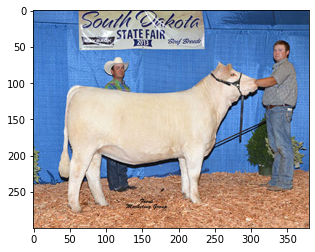

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
class Compose(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels

class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels

class ToTensor(object):
    def __call__(self, cvimage, boxes=None, labels=None):
        return torch.from_numpy(cvimage.astype(np.float32)).permute(2, 0, 1), boxes, labels

class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image, boxes, labels

In [ ]:
class PredictionTransform:
    def __init__(self, size, mean=0.0, std=1.0):
        self.transform = Compose([
            Resize(size),
            SubtractMeans(mean),
            lambda img, boxes=None, labels=None: (img / std, boxes, labels),
            ToTensor()
        ])

    def __call__(self, image):
        image, _, _ = self.transform(image)
        return image

There were no mean and std provided along with training weights, so we'll make a guess `mean = 255 / 2`, `std = 255/3`.

In [ ]:
transform = PredictionTransform(300, 128, 80)

In [ ]:
image = transform(img)
images = image.unsqueeze(0)

In [ ]:
net.eval()

SSD(
  (base_net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Co

In [ ]:
with torch.no_grad():
    scores, boxes = net.forward(images)

In [ ]:
scores[0].shape

torch.Size([3000, 21])

In [ ]:
boxes[0].shape

torch.Size([3000, 4])

In [ ]:
scores

tensor([[[9.7188e-01, 7.5085e-04, 7.7358e-04,  ..., 6.7570e-04,
          7.2598e-04, 1.6350e-03],
         [9.8054e-01, 4.5949e-04, 6.6624e-04,  ..., 5.5201e-04,
          6.3068e-04, 1.1760e-03],
         [9.6588e-01, 1.0191e-03, 9.8713e-04,  ..., 8.4937e-04,
          8.5873e-04, 1.6306e-03],
         ...,
         [6.5034e-02, 1.4138e-04, 4.4475e-03,  ..., 1.6617e-02,
          1.1583e-03, 6.9082e-04],
         [5.2843e-02, 1.6966e-04, 4.7660e-03,  ..., 1.6414e-02,
          1.5428e-03, 7.7013e-04],
         [2.5075e-01, 1.8496e-04, 3.7482e-03,  ..., 1.2768e-02,
          1.1313e-03, 8.0199e-04]]])

In [ ]:
boxes

tensor([[[-0.0085, -0.0125,  0.1030,  0.1047],
         [-0.0687, -0.0866,  0.1589,  0.1665],
         [ 0.0141, -0.0043,  0.1177,  0.0784],
         ...,
         [ 0.0831,  0.2632,  0.8498,  0.9041],
         [ 0.1104,  0.2605,  0.8549,  0.9006],
         [ 0.0960,  0.2491,  0.8355,  0.9052]]])

What to do now?

1. Drop the boxes where we are not confident enough.

In [ ]:
def prob_threshold(scores, boxes, threshold):
    filtered_scores = ...
    filtered_boxes = ...
    return filtered_scores, filtered_boxes

2. NMS

After filtering, multiple boxes can correspond to a single detection. We need to choose "the best one" for each detect.

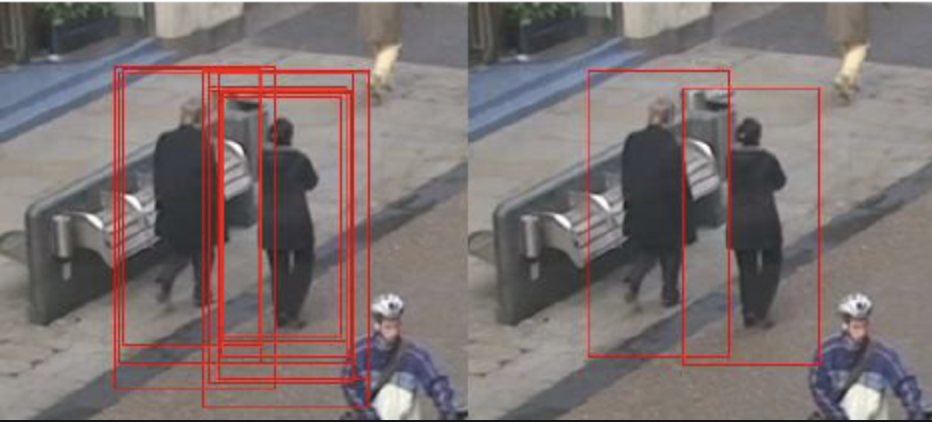

Idea:

  Look at the set of predicted boxes.

  If IOU of two boxes is greater than certain percent: drop one of them, which has lesser score.


In [ ]:
iou = area(intersection) / (area(rectangle1) + area(rectangle2) - area(intersection))

NameError: ignored

In [ ]:
def nms(bboxes, scores, iou_threshold):
    filtered_scores = ...
    filtered_boxes = ...
    return filtered_scores, filtered_boxes

# Assignment [10]

1. Implement `prob_threshold` function.[1]

In [ ]:
def prob_threshold(scores, boxes, threshold):
    indices = ((scores.max(dim=2).indices != 0) & (scores.max(dim=2).values > torch.tensor([threshold]))) # If the max tensor value is not zero, and the max score is greater than our threshold
   
    filter_ = [i for i,x in enumerate(indices[0]) if x]

    filtered_scores = scores[:, filter_]
    filtered_boxes  = boxes[:, filter_]

    return filtered_scores, filtered_boxes

2. Implement `nms` function.[3]

In [ ]:
def nms(bboxes, sscores, iou_threshold):
  availableBoxes = torch.tensor([True]*bboxes.shape[0])
  for i in range(len(bboxes)):
    for j in range(i+1, len(bboxes)):
      if availableBoxes[j] == True and sscores[i].argmax() == sscores[j].argmax():
        boxA = bboxes[i]
        boxB = bboxes[j]
        x_A = max(boxA[0], boxB[0])
        y_A = max(boxA[1], boxB[1])
        x_B = max(boxA[2], boxB[2])
        y_B = max(boxA[3], boxB[3])
     
        areaInterval = max(0, x_B - x_A) * max(0, y_B - y_A)
        areaBoxA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        areaBoxB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        iou = areaInterval / float(areaBoxA + areaBoxB - areaInterval)
        if iou > iou_threshold:
          if sscores[i].max() > sscores[j].max():
            availableBoxes[j] = False
          else:
              availableBoxes[i] = False
              break
      filt = [i for i, x in enumerate(availableBoxes) if x]
      scoresFiltered = torch.tensor(sscores[filt])
      boxesFiltered = torch.tensor(bboxes[filt])
      return scoresFiltered, boxesFiltered



3. Use `iou_threshold 0.5`. Tune `prob_threshold`, so you get not more than 4 predictions on the sample image. [2]

In [ ]:
boxes_1, scores_1 = prob_threshold(scores, boxes, .5)

print(boxes.shape, scores.shape)
print(boxes_1.shape, scores_1.shape)

torch.Size([1, 3000, 4]) torch.Size([1, 3000, 21])
torch.Size([1, 5, 21]) torch.Size([1, 5, 4])


In [ ]:
boxes_2, scores_2 = nms(boxes_1[0], scores_1[0], 0.5)

print(boxes_2.shape, scores_2.shape)

torch.Size([5, 4]) torch.Size([5, 21])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


4. Draw predicted boxes on the image (different colors for different classes). Find out how to draw rectangles in opencv here: https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html. [2]

In [ ]:
for x in boxes_2:
  print(x)

tensor([0.7067, 0.1313, 0.9708, 0.8185])
tensor([0.7563, 0.1405, 0.9705, 0.8094])
tensor([0.0925, 0.2407, 0.8538, 0.9284])
tensor([0.0981, 0.2562, 0.8495, 0.9227])
tensor([0.0884, 0.2335, 0.8681, 0.9268])


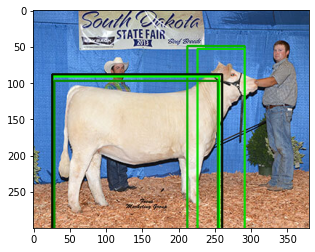

In [ ]:
width, height = img.shape[0],img.shape[1]
from random import randint

for x in boxes_2:
    start = (x[0]*width, x[1]*height)
    end   = (x[2]*width, x[3]*height)
    img   = cv2.rectangle(img, 
                          start,
                          end,
                          (8,randint(0,256),0),
                          2)

plt.imshow(img)
plt.show()

5. Download 4 more images from the internet and repeat the process. [2]

TypeError: ignored

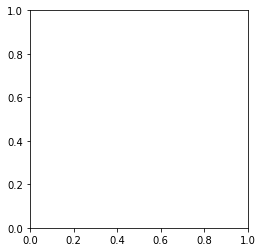

In [ ]:
import cv2 
  
# path 
im_1 = r'C:\Users\anoua\Downloads\images.jfif'
im_2 = r'C:\Users\anoua\Downloads\images(1).jfif'
im_3 = r'C:\Users\anoua\Downloads\download.jfif'
im_4 = r'C:\Users\anoua\Downloads\Giving-birth-to-Life-1080x608.jpg'

img_1 = cv2.imread(im_1) 
img_2 = cv2.imread(im_2) 
img_3= cv2.imread(im_3) 
img_4 = cv2.imread(im_4) 
# Displaying the image 
# cv2.imshow('image_1', img_1) 
# cv2.imshow('image_2', img_2) 
# cv2.imshow('image_3', img_3) 
# cv2.imshow('image_4', img_4) 
plt.imshow(img_4)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img_1 = cv2.imread( r'C:\Users\anoua\Downloads\images.jfif', cv2.IMREAD_UNCHANGED)
cv2_imshow(img_1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0  30054      0 --:--:-- --:--:-- --:--:-- 30054


AttributeError: ignored

In [ ]:
image_1 = transform(img_1)
images_1 = image_1.unsqueeze(0)

net.eval()

with torch.no_grad():
    scores_11, boxes_11 = net.forward(images_1)
print(boxes_11.shape, scores_11.shape)

boxes_1_1, scores_1_1   = prob_threshold(scores_11, boxes_11, .5)
print(boxes_1_1.shape, scores_1_1.shape)

_boxes_1, _scores_1 = nms(boxes_1_1[0], scores_1_1[0], 0.9)
print(_boxes_1.shape, _scores_1.shape)

width_1, height_1 = img_1.shape[0],img_1.shape[1]

for x in _boxes_1:
    start_1 = (x[0]*width_1, x[1]*height_1)
    end_1 = (x[2]*width_1, x[3]*height_1)
    img_1 = cv2.rectangle(img_1, 
                            start_1,
                            end_1,
                            (8,randint(0,256),0),
                          2)

# Result
plt.imshow(img_1)
plt.show()

error: ignored